# Encoder - MVP

Self-supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection.
### VsCode update patch
Initial notebook setup when using VSCode.

In [1]:
# This is only needed if the notebook is run in VSCode
import sys
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    import nbs_pipeline.utils.vscode  as vs
    vs.DisplayHandle.update = vs.update_patch

### Debugging variables

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.

In [2]:
print_flag = False
reset_kernel = True
check_memory_usage = True
time_flag = True
window_size_percentage = False

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.

In [3]:
import utils.config as cfg_
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [4]:
pre_configured_case = True
case_id = 4

## Main code
### Import libraries

In [5]:
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_long_term_forecasting_splits, get_forecasting_splits #TODO: Quitar 1 cuando esté decidida la opción
import wandb
if check_memory_usage: 
    import nbs_pipeline.utils.memory as mem

### Initialize and Configurate Artifact

In [6]:
wandb_api = wandb.Api()

#### Setup CUDA

In [7]:
cuda_device = 0
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    mem.gpu_memory_status(gpu_device)

Used mem: 3042
Used mem: 24576
Memory Usage: [██------------------] 12%


#### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [8]:
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP_SWV(False)
if pre_configured_case: cfg_.force_artifact_config_mvp(config, case_id, print_flag = print_flag, both = print_flag)

Changing to online analysis mode - use_wandb=true


### Setup W&B artiffact

In [9]:
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02c_encoder_MVP-sliding_window_view"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 02c_encoder_MVP-sliding_window_view


In [10]:
if print_flag: cfg_.show_attrdict(config)

In [11]:
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', resume=False,
    name = runname
)

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


### Split data using Sliding Window & Get training artiffact

#### Get W&B train artifact
##### Build artifact selector
Botch to use artifacts offline

In [12]:
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)

In [13]:
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

In [14]:
train_artifact = artifacts_gettr(config.train_artifact)

In [15]:
df_train = train_artifact.to_df()
if print_flag:
    print(df_train.shape)
    display(df_train.head)

wandb:   1 of 1 files downloaded.  


### Get training set
Use `prepare_forecasting_data` from tsai. Must take into account it uses the following variables:
> | Variable         | Definition                                           | Default Value | Value Utilised   |
> |------------------|------------------------------------------------------|---------------|------------------|
> | `df`             | Time series DataFrame.                               | -             | `df_train`       |
> | `fcst_history`   | Input historical steps. Window size.                 | -             | `config.w`       |
> | `fcst_horizon`   | Future predicted steps.                              | `1`           | - (no forecasts) |
> | `x_vars`         | Input variables.                                     | `None`        | - (all columns)  |
> | `y_vars`         | Output variables.                                    | `None`        | -                |
> | `dtype`          | Output datatype (for example, `'float32'`).          | `None`        | -                |
> | `unique_id_cols` | None or unique identifier column id.                 | -             | -                |
> 
> For more information, visit [tsai - data - preparation - prepare_forecasting_data](https://timeseriesai.github.io/tsai/data.preparation.html#prepare_forecasting_data)recasting_data)

In [16]:
if print_flag: 
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)

In [17]:
X_train, _ = prepare_forecasting_data(df_train, fcst_history = config.w)

In [18]:
if print_flag:
    print("X ~", X_train.shape)
    print("stride ~", config.stride)

#### Apply strides
Once we have build the windows, we can apply strides in order to check have the same structure as when used via sliding window
> <span style="color:red"> TODO: Check if it is the same to set fcst_horizon = stride </span>

In [19]:
X_strided = X_train[::config.stride]
X = X_train

- df_train ~ (num_samples, num_vars)
- X_train ~ (num_samples - window_size, num_vars, window_size)
- X_train_strided ~ ((num_samples - window_size)/stride, num_vars, window_size)

In [20]:
print("X ~ ", X.shape)
print("X_strided ~ ", X_strided.shape)

X ~  (50400, 1, 2160)
X_strided ~  (350, 1, 2160)


### Split Training Set into Training and Test Dataset

> Use the `get_forecasting_splits` function from tsai to split your time series data. Understand and adapt the parameters to suit your needs:
>
> | Variable               | Definition                                             | Default Value | Value Utilised     |
> |------------------------|--------------------------------------------------------|---------------|--------------------|
> | `df`                   | DataFrame containing a sorted time series.             | -             | `df_train`         |
> | `fcst_history`         | Number of historical steps used as input.              | -             | `config.w`         |
> | `fcst_horizon`         | Number of steps forecasted into the future.            | `1`           | 1 (no forecasts)   |
> | `stride`               | Strides of the sliding windows (input and target).     | `1`           | `config.stride`    |
> | `valid_size`           | Size of the training set (based on datetimes).         | `0.0`         | `config.valid_size`|
> | `test_size`            | Size of the test set (based on datetimes).             | `0.2`         | `0.2`              |
> | `valid_cutoff_datetime`| First prediction datetime of validation dataset.       | `None`        | -                  |
> | `test_cutoff_datetime` | First prediction datetime of test dataset.             | `None`        | -                  |
> | `datetime_col`         | Column with the datetime values.                       | `None`        | `config.time_col   |
> | `use_index`            | Flag to indicate if datetime is in the index.          | `False`       | `True`             |
> | `unique_id_cols`       | Column/s with the unique identifier/s for each entity. | `None`        | -                  |
> | `show_plot`            | Flag to indicate if splits should be plotted.          | `True`        | `True`             |
>
> For more information, visit [tsai - Splitting data - get_forecasting_splits](https://timeseriesai.github.io/tsai/data.validation.html#get_forecasting_splits).

In [21]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

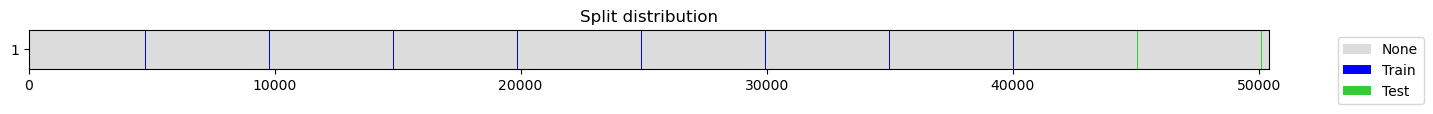

In [22]:
if config.analysis_mode == 'online': 
    splits = get_forecasting_splits(
        df = df_train, 
        fcst_history = config.w,
        fcst_horizon = 1,
        stride = config.stride, 
        test_size = 0.2,
        show_plot = True
    )
    #    splits = TimeSplitter(valid_size=0.2, show_plot=True)(X)
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X_strided)), valid_size=config.valid_size)

if print_flag:
    display(splits)


## MVP - Encoder training
Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [23]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

### Set transformations

In [24]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

### Get data loaders

In [25]:
if print_flag: print(X.shape)
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
if print_flag: display(dls.show_at(0))

#### Check dls

In [26]:
if print_flag:
    print("X ~", X.shape) 
    print("dls batch size", dls.bs)


#### Build MVP TS Learner

##### Auxiliar functions for ensuring absolute/percentage window size management and checking the result.

In [27]:
if (not window_size_percentage):
    from copy import deepcopy
    def ensure_expected_window_size(expected_window_size, print_flag: bool = False):
        window_size = deepcopy(expected_window_size)
        if print_flag: print(window_size)
        window_size[0] = window_size[0] / window_size[1]
        if print_flag: 
            print(window_size)
            print(int(round(window_size[0]*window_size[1])))
        return window_size
    def check_expected_window_size(learn, expected_window_size, print_flag: bool = False):
        # Find MVP calback
        obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
        if print_flag: print("obtained percentage", obtained_window_size)
        obtained_window_size[0] = int(round(obtained_window_size[0]*obtained_window_size[1]))
        if print_flag: print("obtained absolute", obtained_window_size)
        return obtained_window_size == expected_window_size

In [28]:
if not window_size_percentage:
    window_size = ensure_expected_window_size(config.mvp_ws)
else:
    window_size = config.mvp_ws
window_size

[0.000462962962962963, 2160]

##### Initialize learner

In [29]:
sgc = ShowGraphCallback2()
learn = ts_learner(dls, 
                   InceptionTimePlus, 
                   cbs= cbs + sgc + MVP(
                       r = config.r, 
                       window_size=window_size, 
                       future_mask = config.mask_future, 
                       target_dir='./models', 
                       sync = config.mask_sync, 
                       stateful = config.mask_stateful,
                       fname=f'encoder_MVP',
                       verbose=False
                    ), y_range=[X.min(), X.max()])

#### Check learner

In [30]:
if not window_size_percentage:
    check_expected_window_size(learn, config.mvp_ws, print_flag = print_flag)
    if print_flag:
        print("learn dls.bs",  learn.dls.bs)

#### Example mask

##### Create mask

In [31]:
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

##### Show mask

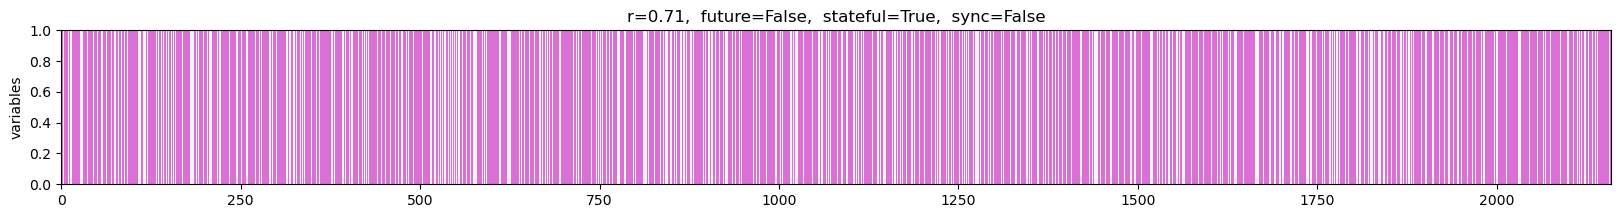

In [32]:
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 #### Check window size configuration

##### Check config attributes

In [33]:
expected_window_size = config.mvp_ws
if print_flag:
    print("w", config.w, "mvp_ws", config.mvp_ws)
    print("expected ", expected_window_size)
    print(*config.mvp_ws)
np.random.randint(*config.mvp_ws)

530

In [34]:
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
if print_flag: print("obtained ", obtained_window_size)
obtained_window_size[0] = int(round(obtained_window_size[0]*obtained_window_size[1]))
if print_flag: print("obtained ", obtained_window_size)

In [35]:
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


##### Check w1 < w2 for MVP random window size selection

In [36]:
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    print(obtained_window_size)
    ws = np.random.randint(*obtained_window_size)
    print(ws)

[1, 2160]
1712


### Train the model

In [37]:
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
if print_flag: print("obtained ", obtained_window_size)

In [38]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

Used mem: 3208
Used mem: 24576
Memory Usage: [██------------------] 13%


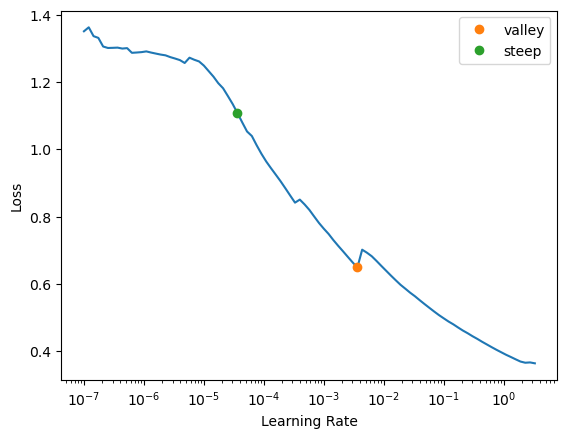

In [39]:
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))

In [40]:
obtained_window_size = deepcopy(learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size)
if print_flag: print("obtained ", obtained_window_size)

In [41]:
if not window_size_percentage:
    if not check_expected_window_size(learn=learn, expected_window_size=config.mvp_ws, print_flag=True):
        learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size = ensure_expected_window_size(config.mvp_ws, True)

obtained percentage [1, 2160]
obtained absolute [2160, 2160]
[1, 2160]
[0.000462962962962963, 2160]
1


In [42]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

Used mem: 13462
Used mem: 24576
Memory Usage: [███████████---------] 55%


epoch     train_loss  valid_loss  time    
0         0.887782    0.759500    00:00     


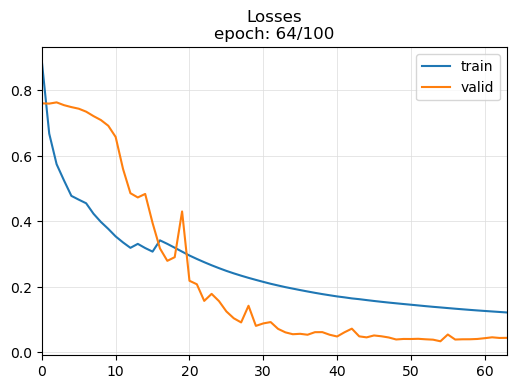

1         0.667004    0.758717    00:00     
2         0.573910    0.762473    00:00     
3         0.524455    0.753964    00:00     
4         0.477349    0.748074    00:00     
5         0.465812    0.743157    00:00     
6         0.454791    0.734135    00:00     
7         0.422836    0.720591    00:00     
8         0.397816    0.708572    00:00     
9         0.376660    0.691183    00:00     
10        0.353666    0.656951    00:00     
11        0.335342    0.559400    00:00     
12        0.318900    0.485479    00:00     
13        0.330975    0.472547    00:00     
14        0.318276    0.483269    00:00     
15        0.307340    0.394867    00:00     
16        0.341748    0.317179    00:00     
17        0.330973    0.279256    00:00     
18        0.319226    0.290360    00:00     
19        0.307283    0.429824    00:00     
20        0.295439    0.218474    00:00     
21        0.285024    0.207815    00:00     
22        0.275125    0.157091    00:00     
23        

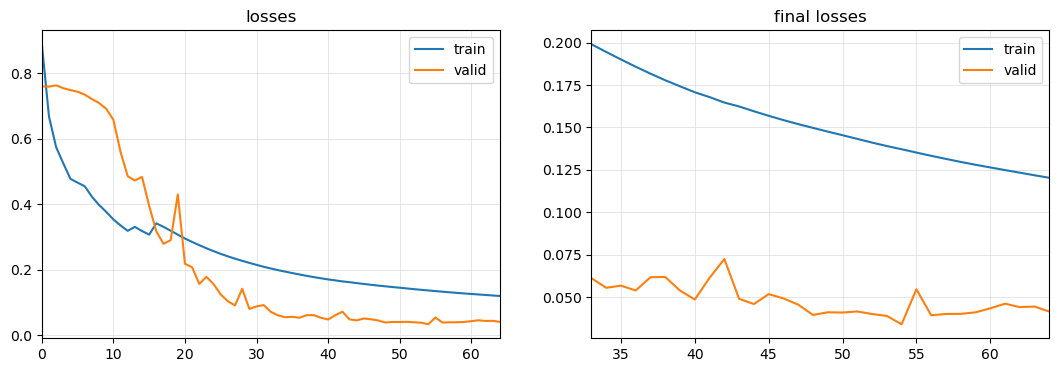

In [43]:
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

In [44]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

Used mem: 13462
Used mem: 24576
Memory Usage: [███████████---------] 55%


#### Validate the model

In [45]:
if not window_size_percentage:
    if not check_expected_window_size(learn=learn, expected_window_size=config.mvp_ws, print_flag=True):
        learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0].window_size = ensure_expected_window_size(config.mvp_ws, True)

obtained percentage [1, 2160]
obtained absolute [2160, 2160]
[1, 2160]
[0.000462962962962963, 2160]
1


In [46]:
learn.validate()

not enough values to plot a chart


(#1) [0.716133177280426]

## Visualize predictions

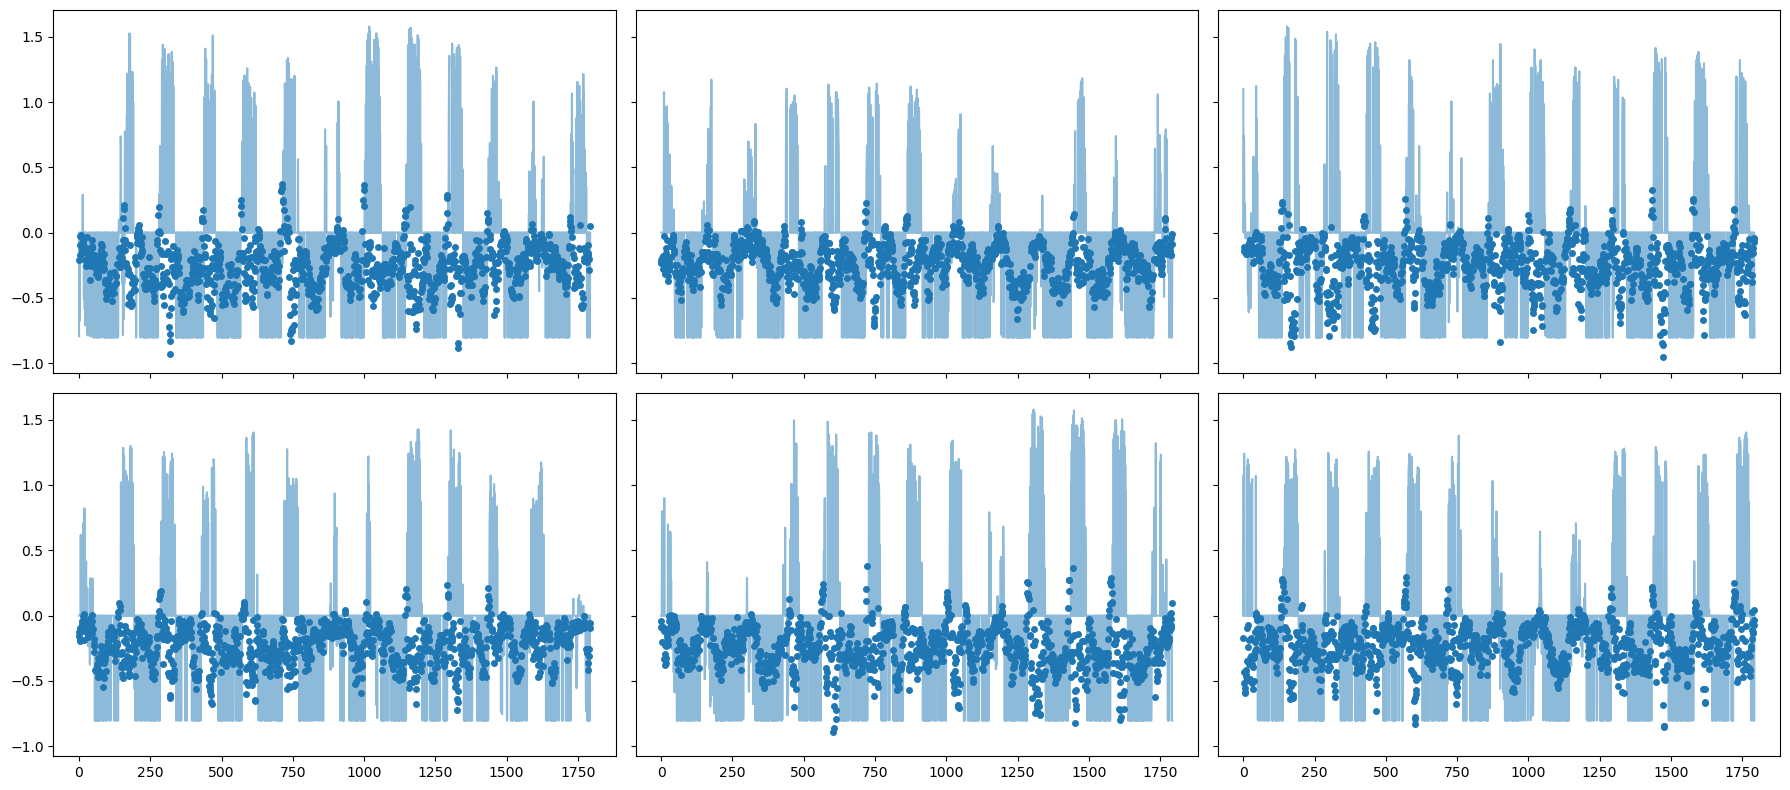

In [47]:
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [48]:
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
learn.remove_cb(sgc)

In [49]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp-SWV', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [50]:
run.finish()

epoch,65
eps_0,1e-05
eps_1,1e-05
lr_0,0.0017
lr_1,0.0017
mom_0,0.90314
mom_1,0.90314
raw_loss,0.06766
sqr_mom_0,0.99
sqr_mom_1,0.99
train_loss,0.12031


In [ ]:
print("Execution ended")
if reset_kernel:
    import os
    os._exit(00)

Execution ended
